In [81]:
from langgraph.graph import StateGraph,END
import random
from typing import Optional,TypedDict,Dict,List

In [82]:
class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int

In [83]:
def greeting_node(state: AgentState) -> AgentState:
    """Greeting Node which says hi to the person"""
    state["name"] = f"Hi there, {state["name"]}"
    state["counter"] = 0 

    return state

def random_node(state: AgentState) -> AgentState:
    """Generates a random number from 0 to 10"""
    state["number"].append(random.randint(0, 10))
    state["counter"] += 1

    return state


def should_continue(state: AgentState) -> AgentState:
    """Function to decide what to do next"""
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"  # Continue looping
    else:
        return "exit"  # Exit the loop
    

In [84]:
# greeting → random → random → random → random → random → END

In [85]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")


graph.add_conditional_edges(
    "random",     # Source node
    should_continue, # Action
    {
        "loop": "random",  
        "exit": END          
    }
)

graph.set_entry_point("greeting")

app = graph.compile()

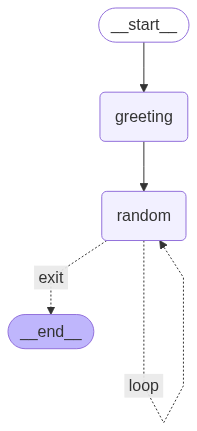

In [86]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [87]:
app.invoke({"name":"Vaibhav", "number":[], "counter":-100})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'Hi there, Vaibhav', 'number': [1, 3, 2, 8, 5], 'counter': 5}

In [88]:
## Exercise 5

In [89]:
""" 
Your task 

Make a graph on right! You need to implement an Automatic Higher or Lower Game

Set the brounds to between 1 to 20. The graph has to keep guessing (max number of guess is 7)
where if guess is correct, then it stops.

But if now we keep looping untill we hit the max limit of 7.

Each time a number is guessed, the hint node should say higher or lower and graph
should account for this information and guess the next guess accordingly.

Input: {"player_name":"Student","guesses":[],"attempts": 0, "lower_bound":1,"upper_bound":20}
Hint: It will need to adjust its bounds after every guess based on hint provided by hint node.

For example, if the guess is higher than the number, then the hint node will say "lower" and the graph
should account for this information and guess the next guess accordingly.



"""

' \nYour task \n\nMake a graph on right! You need to implement an Automatic Higher or Lower Game\n\nSet the brounds to between 1 to 20. The graph has to keep guessing (max number of guess is 7)\nwhere if guess is correct, then it stops.\n\nBut if now we keep looping untill we hit the max limit of 7.\n\nEach time a number is guessed, the hint node should say higher or lower and graph\nshould account for this information and guess the next guess accordingly.\n\nInput: {"player_name":"Student","guesses":[],"attempts": 0, "lower_bound":1,"upper_bound":20}\nHint: It will need to adjust its bounds after every guess based on hint provided by hint node.\n\nFor example, if the guess is higher than the number, then the hint node will say "lower" and the graph\nshould account for this information and guess the next guess accordingly.\n\n\n\n'

In [90]:
from langgraph.graph import  StateGraph,END 
import random
from typing import Dict, List,TypedDict

In [91]:
class GameState(TypedDict):
    player_name: str
    target_number: int 
    guesses: List[int]
    attempts: int
    lower_bound: int
    upper_bound: int

In [92]:
def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1 
    state["upper_bound"] = 20 
    print(f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20.")
    return state

In [93]:
def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        
        guess = random.randint(state["lower_bound"], state["upper_bound"])
    
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")
    return state

In [94]:
def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]
    
    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"
        
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")
    
    return state

In [95]:
def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

In [96]:
graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)  


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")  


graph.add_conditional_edges(
    "hint_node", 
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

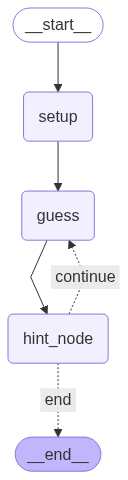

In [97]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [98]:
result = app.invoke({"player_name": "Student", "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20})

Welcome, Student! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 3 (Current range: 1-20)
Hint: The number 3 is too low. Try higher!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 12 (Current range: 4-20)
Hint: The number 12 is too low. Try higher!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 17 (Current range: 13-20)
Hint: The number 17 is too high. Try lower!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 15 (Current range: 13-16)
Hint: The number 15 is too high. Try lower!
CONTINUING: 4/7 attempts used
Attempt 5: Guessing 14 (Current range: 13-14)
Hint: The number 14 is too high. Try lower!
CONTINUING: 5/7 attempts used
Attempt 6: Guessing 13 (Current range: 13-13)
Success! Correct! You found the number 13 in 6 attempts.
GAME OVER: Number found!


In [ ]:
1:29